# Import local .csv

In [26]:
import pandas as pd

%reload_ext autoreload
%autoreload 2

df = pd.read_csv('cust_act1.csv')

df.skew(numeric_only=True)

administrative              1.930426
administrative_duration     4.666608
informational               3.201809
informational_duration      7.202650
product_related             3.321367
product_related_duration    3.643645
bounce_rates                2.949097
exit_rates                  2.194420
page_values                 6.023549
weekend                     1.450999
revenue                     1.908652
dtype: float64

# Perform column dtype transform

In [27]:
from db_utils import DataTransform
from db_utils import DataFrameInfo as dfinfo

display(df.info())
print("Here's the no. of null values in each column:\n", df.isna().sum())
dtype_change = {
    "visitor_type": "category",
    "traffic_type": "category",
    "region": "category",
    "browser": "category",
    "operating_systems": "category",
    # "months": "category" -- Special case
    "administrative": "Int32",
    "informational": "Int32",
    "product_related": "Int32"
}

""" dfinfo(df, 'operating_systems').unique()
print("\n", df['operating_systems'].value_counts())
print(df['operating_systems'].isna().sum()) """

# Perform special transform case for months to be an ordered category
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month'] = pd.Categorical(df['month'], categories=months_ordered, ordered=True)
# Perform the transform from dict
df = DataTransform(df).changetype(dtype_change)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

None

Here's the no. of null values in each column:
 administrative              570
administrative_duration     912
informational                 0
informational_duration      336
product_related             579
product_related_duration    201
bounce_rates                  0
exit_rates                    0
page_values                   0
month                         0
operating_systems            11
browser                       0
region                        0
traffic_type                  0
visitor_type                  0
weekend                       0
revenue                       0
dtype: int64
Successfully changed 'visitor_type' to category
Successfully changed 'traffic_type' to category
Successfully changed 'region' to category
Successfully changed 'browser' to category
Successfully changed 'operating_systems' to category
Successfully changed 'administrative' to Int32
Successfully changed 'informational' to Int32
Successfully changed 'product_related' to Int32
<class 'pandas.core.f

# Display No. and % of Null values

In [28]:
# print(f"\tNo. null:\n\n{df.isna().sum()}\n\n\tPercent Null:\n\n{(df.isna().sum())/len(df)*100}")

nulldf = dfinfo(df).null()
display(nulldf)

dfinfo(df, 'informational').unique()
#df.loc[nulldf['ColumnName']=='informational']
print('\n')
dfinfo(df, 'administrative').unique()
print(df['administrative'].value_counts())
print('\n')
dfinfo(df, 'browser').unique()
print('\n')
dfinfo(df, 'product_related').unique()
print('\n')
dfinfo(df, 'traffic_type').unique()

print(df.isna().sum())


,ColumnName,CountNull,PercentageNull
0,administrative,570,4.62
1,administrative_duration,912,7.40
2,informational,0,0.00
3,informational_duration,336,2.73
4,product_related,579,4.70
5,product_related_duration,201,1.63
6,bounce_rates,0,0.00
7,exit_rates,0,0.00
8,page_values,0,0.00
9,month,0,0.00


Here are the unique values in 'informational':
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


Here are the unique values in 'administrative':
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, <NA>}
administrative
0     5644
1     1237
2     1018
3      885
4      661
5      541
6      401
7      314
8      259
9      227
10     165
11      97
12      93
13      65
14      42
15      37
16      25
17      15
18      14
21       5
19       5
23       4
24       4
20       2
Name: count, dtype: Int64


Here are the unique values in 'browser':
{'Mozilla Firefox', 'Microsoft Edge', 'Sogou Explorer', 'UC Browser', 'Internet Explorer', 'Safari', 'Google Chrome', 'Opera', 'Yandex', 'QQ', 'Undetermined', 'Samsung Internet', 'Android'}


Here are the unique values in 'product_related':
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,

# Imputation Time

In [29]:
from db_utils import DataFrameTransform as dft

%reload_ext autoreload
%autoreload 2

cols_to_impute = [
    "product_related_duration",
    "informational_duration",
    "administrative_duration"
]
cols_to_drop = [
    "operating_systems"
]
cols_to_mode = [
    "administrative",
    "product_related"
]

dft(df, cols_to_drop).drop_missing()
dft(df, cols_to_impute).impute_missing()
dft(df, cols_to_mode).impute_missing(strategy="mode")

print(df.isna().sum())

Dropped 11 rows with missing values in ['operating_systems'].
Before imputation: 201 nulls in 'product_related_duration'
After imputation: 0 nulls in 'product_related_duration'
Imputed missing values in 'product_related_duration' with median (586.00, skew=3.64).
Before imputation: 336 nulls in 'informational_duration'
After imputation: 0 nulls in 'informational_duration'
Imputed missing values in 'informational_duration' with median (0.00, skew=7.21).
Before imputation: 912 nulls in 'administrative_duration'
After imputation: 0 nulls in 'administrative_duration'
Imputed missing values in 'administrative_duration' with median (6.00, skew=4.67).
Imputed missing values in 'administrative' with mode (0).
Imputed missing values in 'product_related' with mode (1).
administrative              0
administrative_duration     0
informational               0
informational_duration      0
product_related             0
product_related_duration    0
bounce_rates                0
exit_rates           

/Users/kiprs/Documents/code_school/py/learning-journey-AICore/Retail EDA 1.1/exploratory-data-analysis---online-shopping-in-retail986/db_utils.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna(value, inplace=True)
/Users/kiprs/Documents/code_school/py/learning-journey-AICore/Retail EDA 1.1/exploratory-data-analysis---online-shopping-in-retail986/db_utils.py:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior 

# Skewness Reduction Transformations

Original DataFrame:


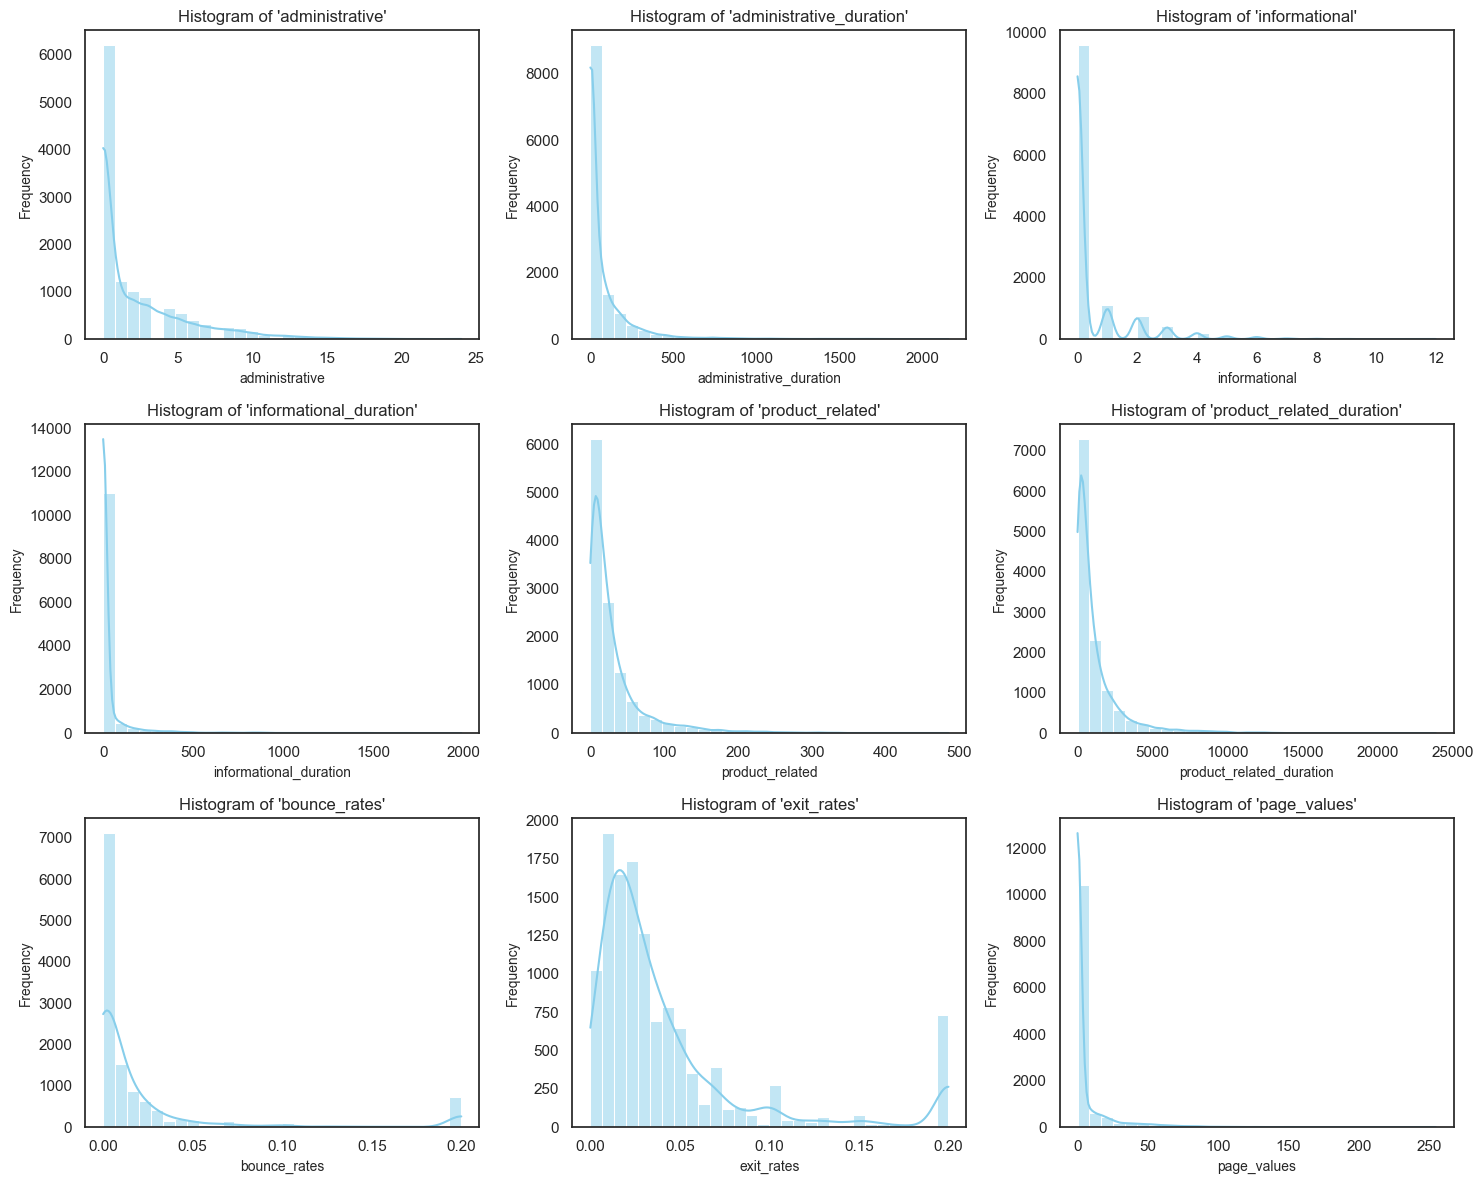


Log-Transformed DataFrame:


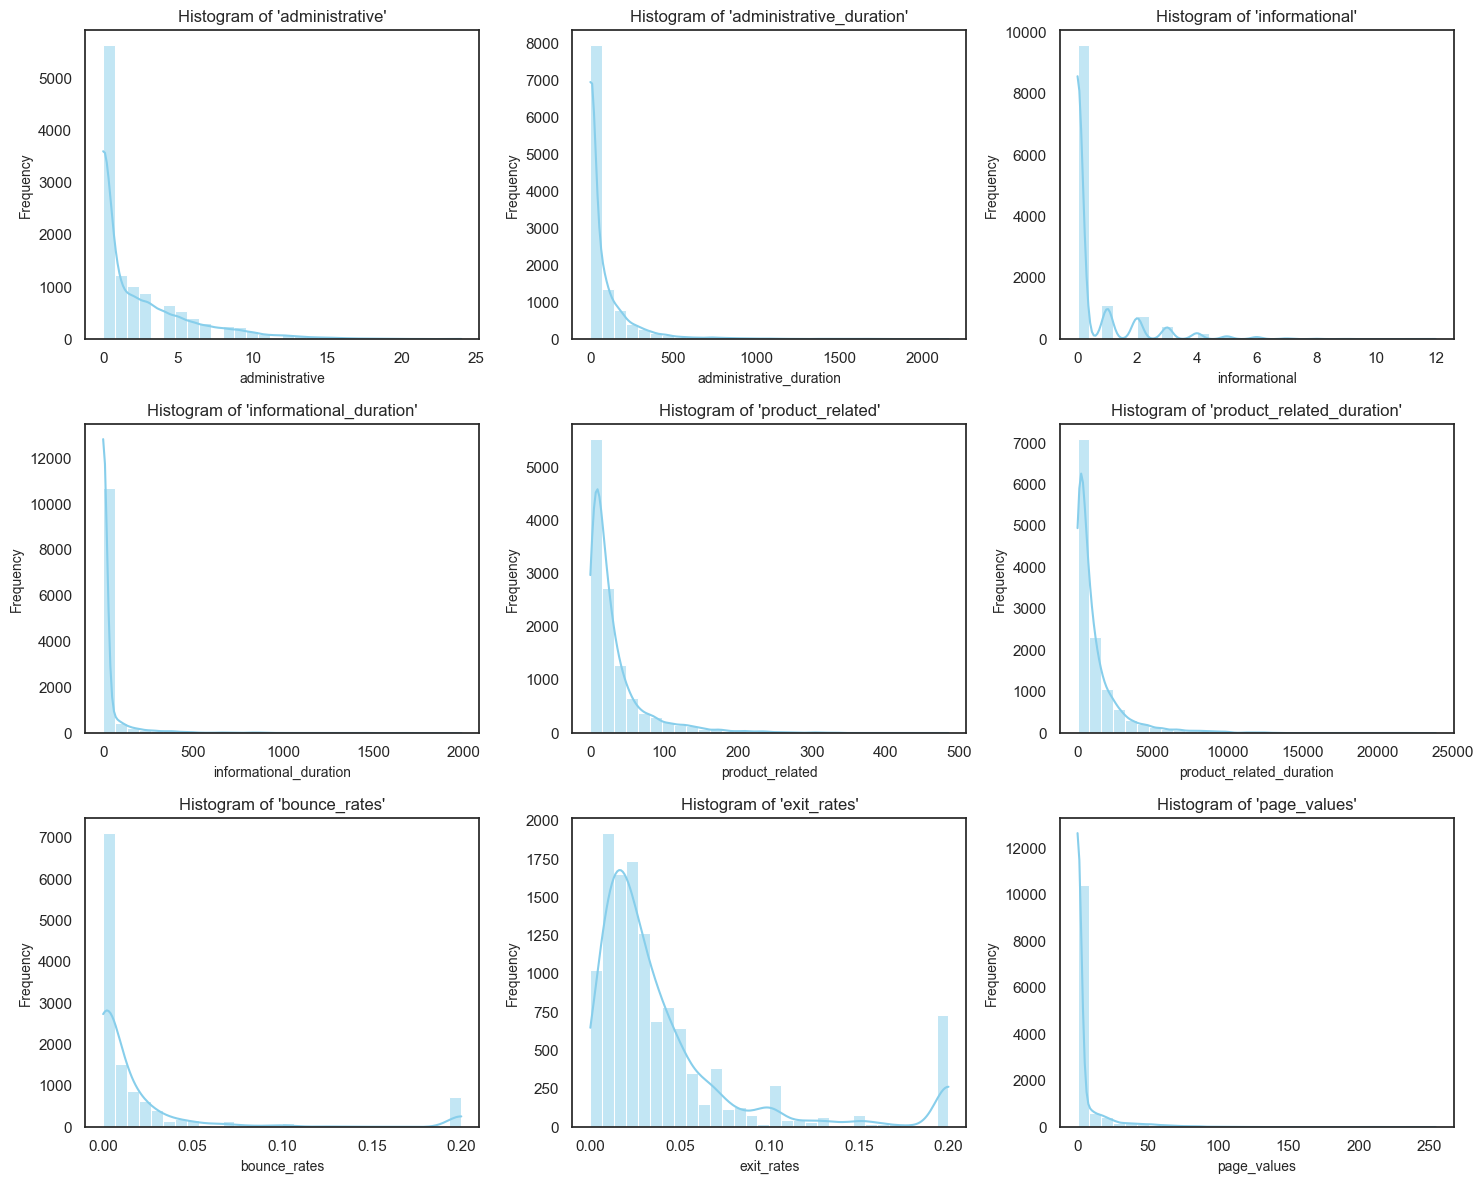


Power-Transformed DataFrame:


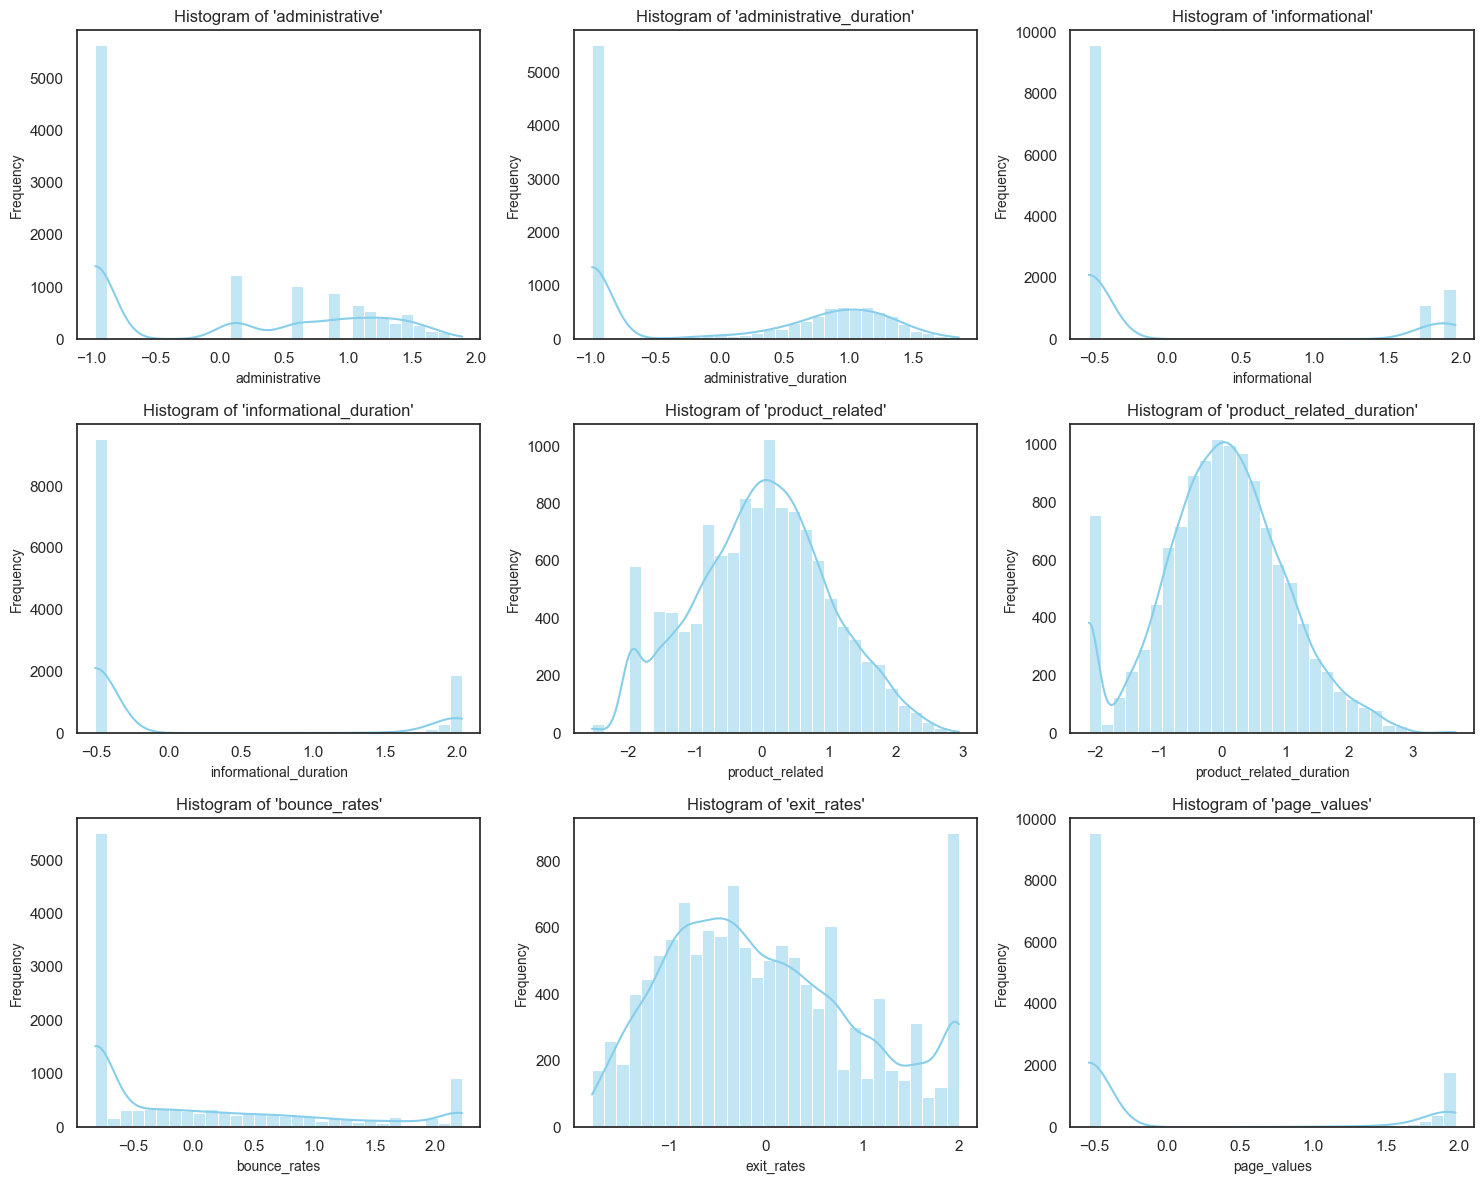

In [30]:
from db_utils import Plotter

df.skew(numeric_only=True)

print("Original DataFrame:")
Plotter(df).numeric_distributions()

# Apply log transformation
log_transformed_df = dft(df).reduce_skewness(method='log')
print("\nLog-Transformed DataFrame:")
Plotter(log_transformed_df).numeric_distributions()

# Apply PowerTransformer
power_transformed_df = dft(df).reduce_skewness(method='power')
print("\nPower-Transformed DataFrame:")
Plotter(power_transformed_df).numeric_distributions()



# Outlier Purge

### Before:

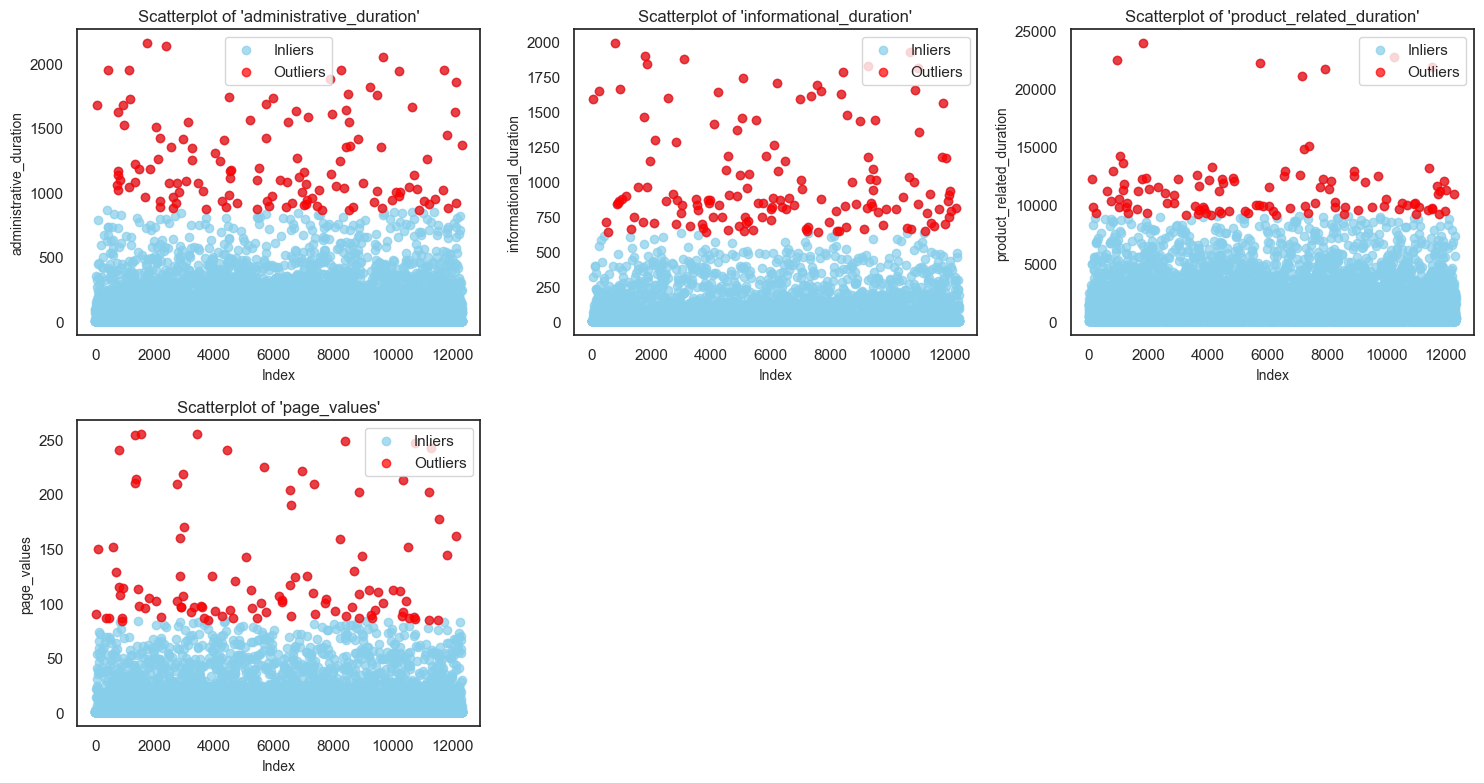

,Column,Z-Score Outliers,Z Percentage,IQR Outliers,IQR Percentage
0,administrative_duration,113,0.917282,1160,9.416349
1,informational_duration,138,1.120221,2474,20.082799
2,product_related_duration,106,0.860459,1032,8.377303
3,page_values,102,0.827989,2782,22.583002


In [31]:
cols_with_outliers = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration",
    "page_values"
]

Plotter(df).numeric_distributions(columns=cols_with_outliers, plot_type='scatter', z_threshold=4.5)

dfinfo(df, cols_with_outliers).count_outliers(z_treshold=4.5)

### Perform removal, assign to new dataframe

In [32]:
df_sans_outliers = dft(df, columns=cols_with_outliers).drop_outliers(z_threshold=4.5)

### After:

/Users/kiprs/Documents/code_school/py/learning-journey-AICore/Retail EDA 1.1/exploratory-data-analysis---online-shopping-in-retail986/db_utils.py:472: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.show()


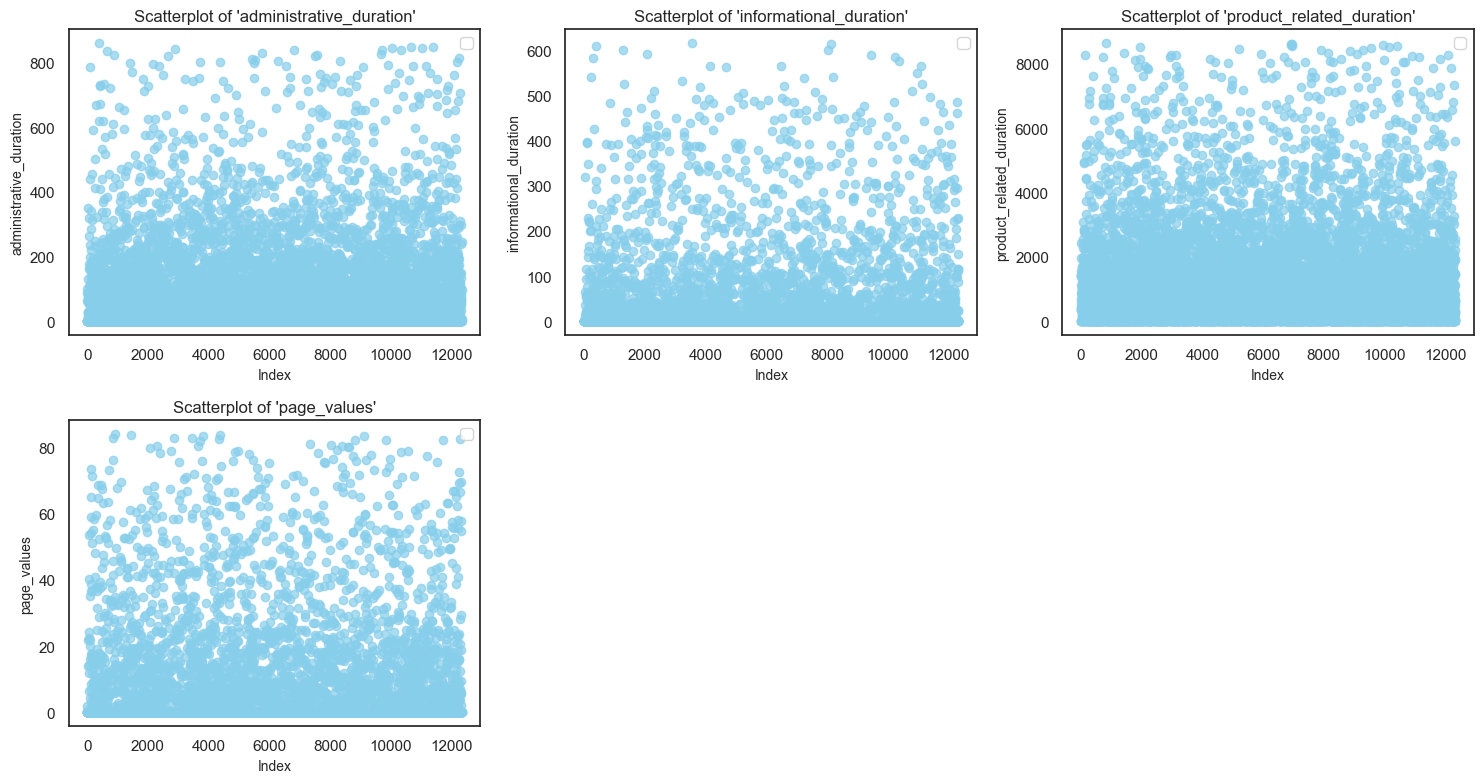

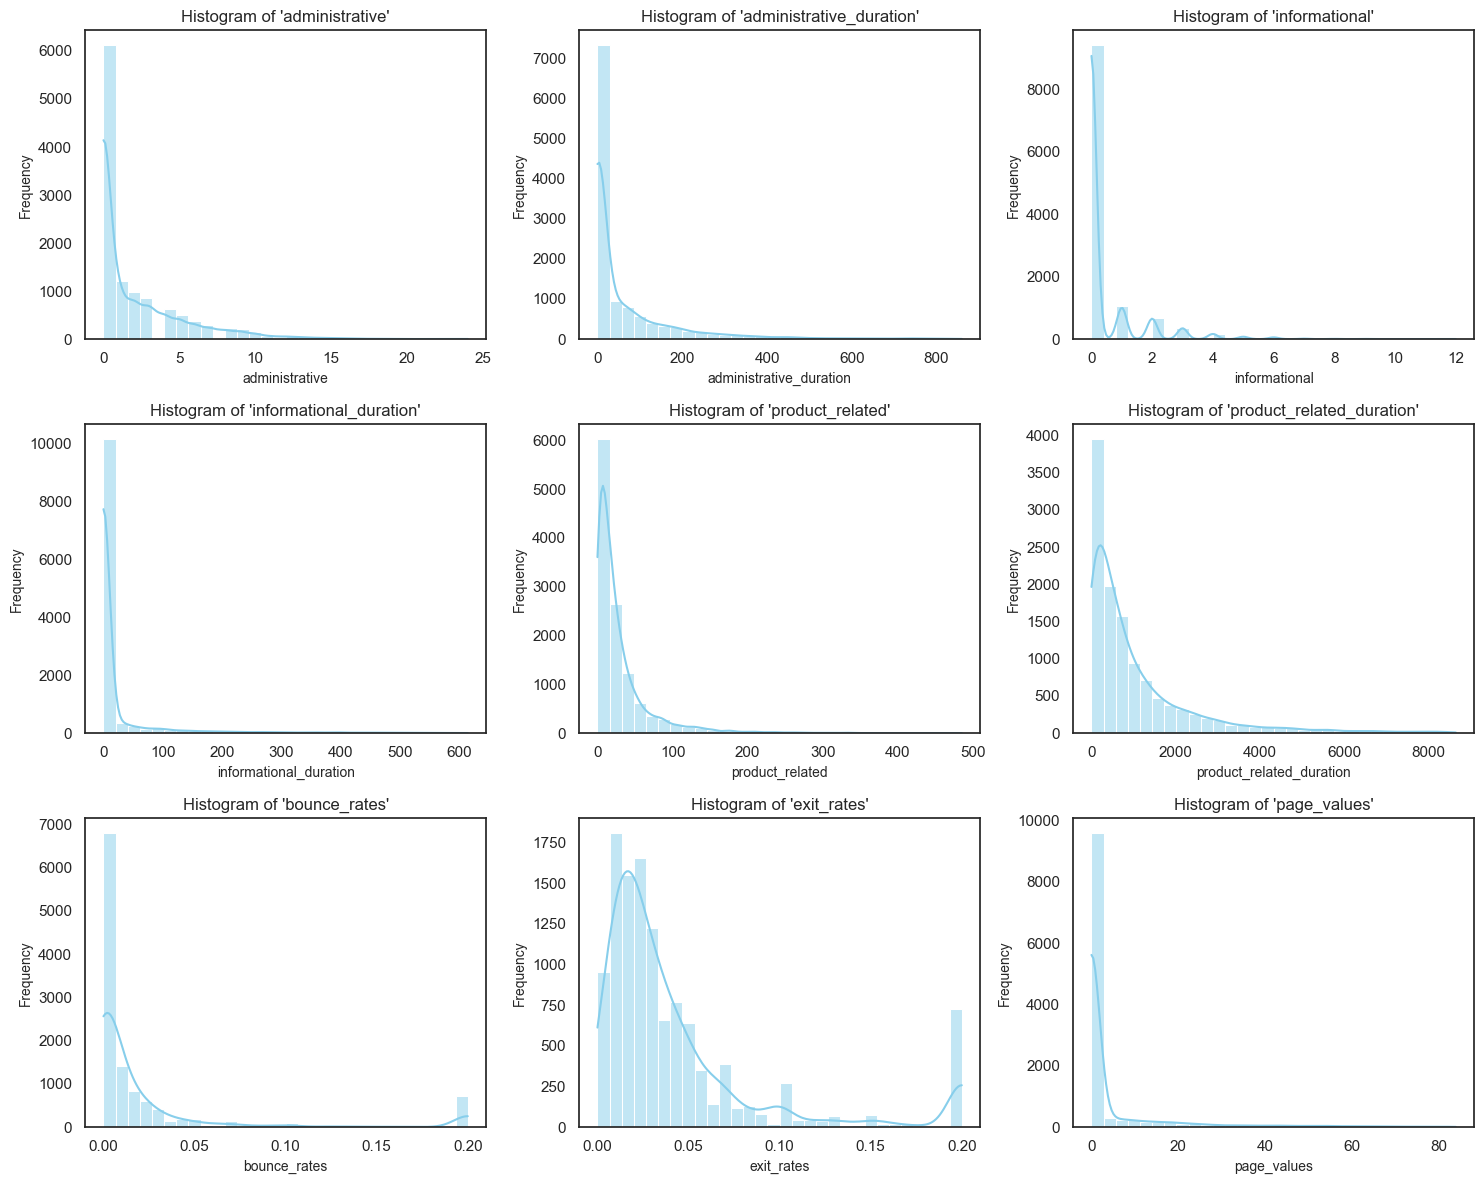

In [33]:
%reload_ext autoreload
%autoreload 2

Plotter(df_sans_outliers).numeric_distributions(columns=cols_with_outliers, plot_type='scatter', highlight_outliers=False)
Plotter(df_sans_outliers).numeric_distributions(plot_type='hist')

# Visualise Correlation Heatmap

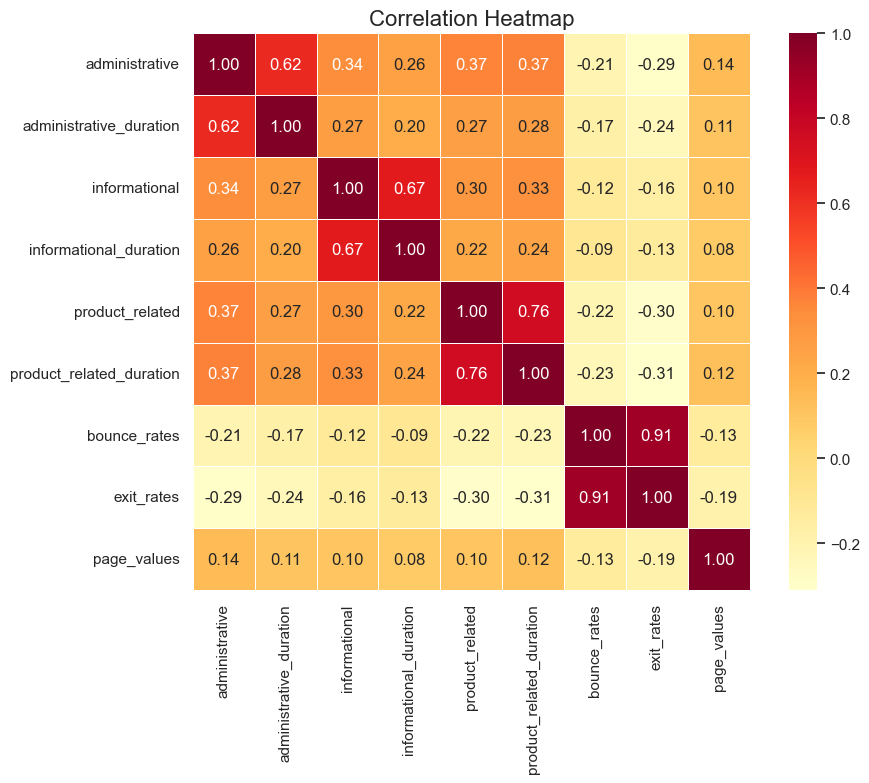

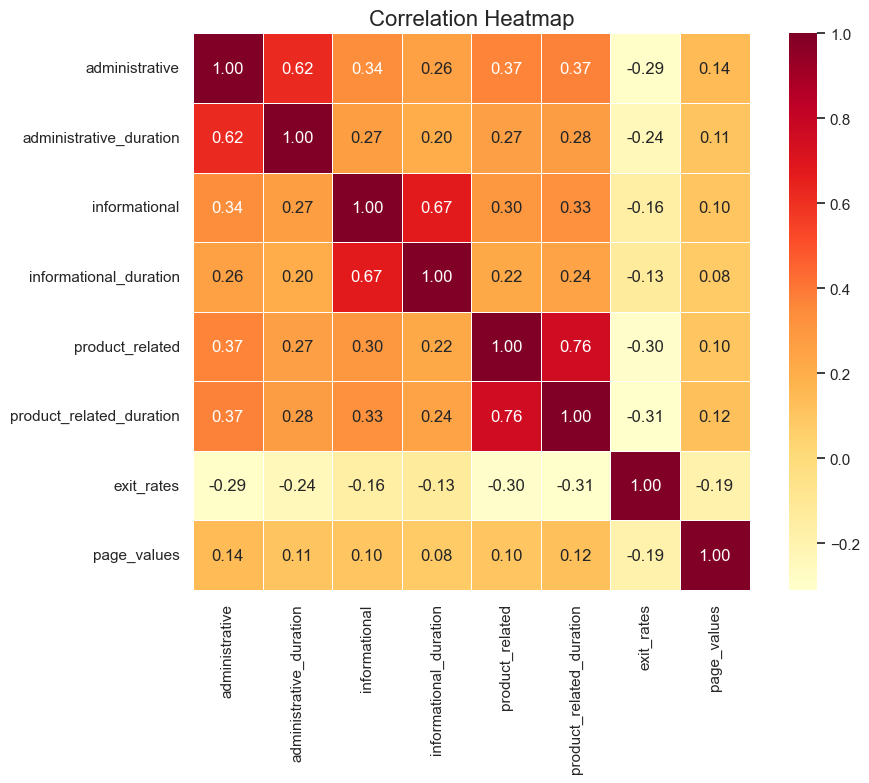

In [ ]:
%reload_ext autoreload
%autoreload 2

plot = Plotter(df_sans_outliers)
plot.correlation_map()

if "bounce_rates" in df_sans_outliers.columns:
    df_sans_outliers = df_sans_outliers.drop(columns="bounce_rates")

plot = Plotter(df_sans_outliers)
plot.correlation_map()


# Missingness Correlation

Plot whether missing values in one column correlate with missing values in other columns.

*Spoiler alert: there doesn't seem to be correlation.*

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_null_correlation_heatmap(df):
    """
    Creates a heatmap showing correlations between missingness indicators for columns.
    Filters columns with no missing values and reorders them for better clarity.

    Args:
        df (pd.DataFrame): The dataframe to analyze.
    """
    # Create a missingness indicator DataFrame
    null_indicator = df.isnull()
    
    # Filter columns with at least some missing values
    missing_cols = null_indicator.loc[:, null_indicator.any()].columns
    
    # Subset to columns with missing values
    null_corr = null_indicator[missing_cols].corr()
    
    # Sort columns to cluster similar missingness patterns
    sorted_columns = null_corr.sum().sort_values(ascending=False).index
    null_corr = null_corr.loc[sorted_columns, sorted_columns]
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))  # Adjust the figure size for readability
    sns.heatmap(
        null_corr,
        cmap="coolwarm",  # Use a visually intuitive color map
        annot=True,       # Add annotations
        fmt=".2f",        # Format annotations with 2 decimal points
        linewidths=0.5,   # Add space between cells
        cbar_kws={'label': 'Correlation'}
    )
    plt.title("Correlation of Missingness Between Columns", fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for clarity
    plt.yticks(fontsize=10)  # Adjust y-axis label font size
    plt.tight_layout()
    plt.show()

plot_null_correlation_heatmap(df)


# Browser per Region

In [ ]:
import plotly.express as px

fig = px.histogram(df, "browser", 
                   facet_col="operating_systems", 
                   color="operating_systems",
                   title="Counts of browser per operating_systems",
                   labels={"browser": "browser"},
                   height=1000, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   histnorm='probability'
                   )
fig.update_layout(showlegend=False, xaxis={'categoryorder':'total descending'})
fig.update_yaxes(matches=None, showticklabels=True)
# fig.update_xaxes(showticklabels=True)
fig.show()

# Chart Boilerplate Collection

#### 1. Transparent Circle Scatter Plot

In [ ]:
# This is copied straight from another db analysis.
# TODO all variables and categories must be replaced with relevant ones.

category_array = ["I have never written code", "< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"]
# fig = px.scatter(programming_experience_salary_df, "Programming Experience", "Salary", title="Density of Programming Experience vs Salary")
fig = px.scatter(programming_experience_salary_df, "Programming Experience", "Salary", facet_col=df["Q2"],title="Density of Programming Experience vs Salary")
fig.update_traces(marker=dict(
            opacity=0.05,
            size=20,
            line=dict(
                color='MediumPurple',
                width=0.5
            )))
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':category_array})
fig.show()